In [142]:
import numpy as np
import sys, pickle, csv
import cv2

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, auc, roc_curve

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input as VGG19_preprocess
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as InceptionV3_preprocess
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as ResNet50V2_preprocess
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input as Xception_preprocess

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline


from skimage.segmentation import mark_boundaries
from lime import lime_image
import lime

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # memory increase is needed before starting program
        print(e)

In [143]:
# load dataset

image_dim = 384


#dpath_original = 'D:kvasir_cls/kvasir-dataset-v2'
dpath_preprocess = 'D:/kvasir_cls'

with open(dpath_preprocess +'/kvasir_cls_'+str(image_dim)+'no_polyp'+'.pickle', 'rb') as f:
    [X,Y] = pickle.load(f)
    print(X.shape, Y.shape)

with open(dpath_preprocess +'/kvasir_cls_'+str(image_dim)+'polyp' + '.pickle', 'rb') as w:
    [X_polyp, Y_polyp] =  pickle.load(w)
    print(X_polyp.shape, Y_polyp.shape)

assert np.max(X) == 255
assert np.min(X) == 0
assert np.max(X_polyp) == 255
assert np.min(X_polyp) == 0

# rest dataset split
X_trnval_no, X_tst_no, Y_trnval_no, Y_tst_no = train_test_split(X, Y, test_size = 1.5 / 10, random_state = 27407, stratify = Y)
X_trn_no, X_val_no, Y_trn_no, Y_val_no = train_test_split(X_trnval_no, Y_trnval_no, test_size = 1.5 / 8.5, random_state = 27407, stratify = Y_trnval_no)

# polyp split
X_trnval_polyp, X_tst_polyp, Y_trnval_polyp, Y_tst_polyp = train_test_split(X_polyp, Y_polyp, test_size = 1.5 / 10, random_state = 27407)
X_trn_polyp, X_val_polyp, Y_trn_polyp, Y_val_polyp = train_test_split(X_trnval_polyp, Y_trnval_polyp, test_size = 1.5 / 8.5, random_state = 27407)

# concatenation and onehot encoding
enc = OneHotEncoder(sparse=False)

X_trn = np.concatenate((X_trn_no, X_trn_polyp), axis=0)
Y_trn = np.concatenate((Y_trn_no, Y_trn_polyp))
Y_trn = enc.fit_transform(Y_trn)

n_class = Y_trn.shape[1]
print("total class number: ", n_class)

X_val = np.concatenate((X_val_no, X_val_polyp), axis=0)
Y_val = np.concatenate((Y_val_no, Y_val_polyp), axis=0)
Y_val = enc.fit_transform(Y_val)

X_tst = np.concatenate((X_tst_no, X_tst_polyp), axis=0)
Y_tst = np.concatenate((Y_tst_no, Y_tst_polyp), axis=0)
Y_tst = enc.fit_transform(Y_tst)


print('trn.shape', X_trn.shape, Y_trn.shape)
print('val.shape', X_val.shape, Y_val.shape)
print('tst.shape', X_tst.shape, Y_tst.shape)

with open("D:/"+"kvasir" + "/kvasir_" + str(image_dim) + '.pickle', 'rb') as q:
    [X_seg, Y_seg] = pickle.load(q)
    print(X_seg.shape, Y_seg.shape)
    
Y_seg = np.expand_dims(Y_seg, 3)

assert np.max(X_seg) == 255
assert np.min(X_seg) == 0
assert np.max(Y_seg) == 1
assert np.min(Y_seg) == 0

# polyp split
X_trnval_s, X_tst_s, Y_trnval_s, Y_tst_s = train_test_split(X_seg, Y_seg, test_size = 1.5 / 10, random_state = 27407)
X_trn_s, X_val_s, Y_trn_s, Y_val_s = train_test_split(X_trnval_s, Y_trnval_s, test_size = 1.5 / 8.5, random_state = 27407)

(7000, 384, 384, 3) (7000, 1)
(1000, 384, 384, 3) (1000, 1)
total class number:  8
trn.shape (5600, 384, 384, 3) (5600, 8)
val.shape (1200, 384, 384, 3) (1200, 8)
tst.shape (1200, 384, 384, 3) (1200, 8)
(1000, 384, 384, 3) (1000, 384, 384)


In [178]:
model_id = 4   # 1, 2, 3, 4
model_list = ["VGG19", "InceptionV3", "ResNet50V2", "Xception"]

if model_id == 1:
    model = load_model('D:/kvasir_cls/models/' + 'kvasir_cls_' + model_list[model_id - 1] + '.h5')
    preprocess_func = VGG19_preprocess
    last_conv_layer_name = 'block5_conv4'
elif model_id == 2:
    model = load_model('D:/kvasir_cls/models/' +'kvasir_cls_' + model_list[model_id - 1] + '.h5')
    preprocess_func = InceptionV3_preprocess
    last_conv_layer_name = 'mixed10'
elif model_id == 3:
    model = load_model('D:/kvasir_cls/models/' +'kvasir_cls_' + model_list[model_id - 1] + '.h5')
    preprocess_func = ResNet50V2_preprocess
    last_conv_layer_name = 'conv5_block3_out'
elif model_id == 4:
    model = load_model('D:/kvasir_cls/models/' +'kvasir_cls_' + model_list[model_id - 1] + '.h5')
    preprocess_func = Xception_preprocess
    last_conv_layer_name = 'block14_sepconv2_act'

In [168]:
from XAI_lime import XAI_lime

In [179]:
limer = XAI_lime(model, model_list[model_id-1], preprocess_func)

In [186]:
idx = 9

  0%|          | 0/1000 [00:00<?, ?it/s]

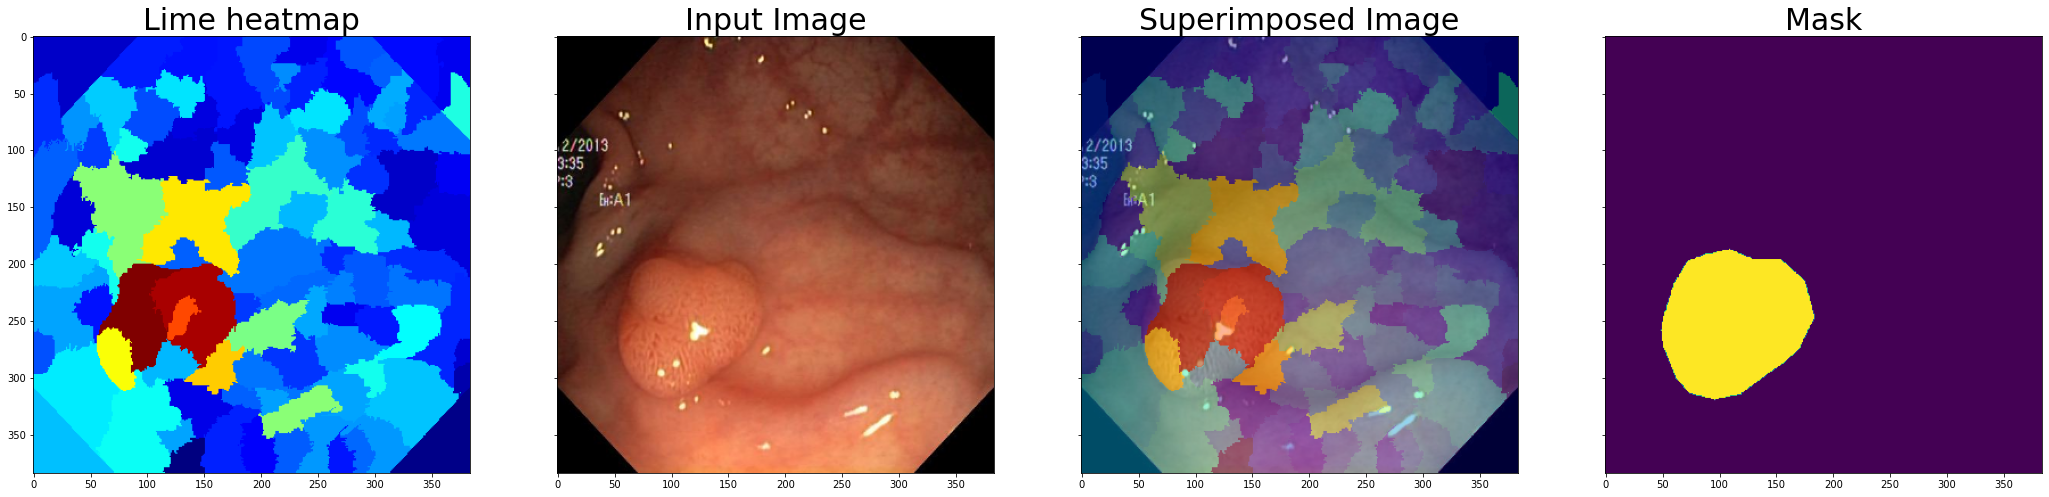

In [187]:
limer.lime_single_visualize(X_tst_s[idx], Y_tst_s[idx], 0.4)